# Churn prediction for an energy company 🔌💡
## Part 2 - Data Exploration and Feature Engineering
### Importing packages and data

In [34]:
from utils import *

repo_path = "/workspaces/myfolder/energy-churn-prediction"

client_file_path = f"{repo_path}/data/client_data_cleaned.csv"
client_date_cols = ['date_activ', 'date_modif_prod', 'date_renewal', 'date_end']

price_file_path = f"{repo_path}/data/price_data_cleaned.csv"
price_date_col = 'price_date'

# Load the data and convert datetime columns
client_df = load_and_convert_datetime(client_file_path, client_date_cols)
price_df = load_and_convert_datetime(price_file_path, [price_date_col])

### Merging the 2 tables

Let's start with `price_df`, and let's have a look at the distinct values of `price_date` variable and at the number of unique IDs contained in this table:

In [35]:
print(f"Number of unique IDs: {price_df['id'].nunique()}")
print("\n------------------------------------------------\n")
print("Distinct values of the 'price_date' variable:")
price_df[price_date_col].value_counts().sort_index()

Number of unique IDs: 16096

------------------------------------------------

Distinct values of the 'price_date' variable:


price_date
2015-01-01    16070
2015-02-01    16082
2015-03-01    16074
2015-04-01    16079
2015-05-01    16080
2015-06-01    16085
2015-07-01    16090
2015-08-01    16094
2015-09-01    16082
2015-10-01    16085
2015-11-01    16087
2015-12-01    16094
Name: count, dtype: int64

From the information above, we can infer that this table provides information on price values from January to December 2015 for 16096 customers. However, it seems that there are some missing values here and there for some IDs:

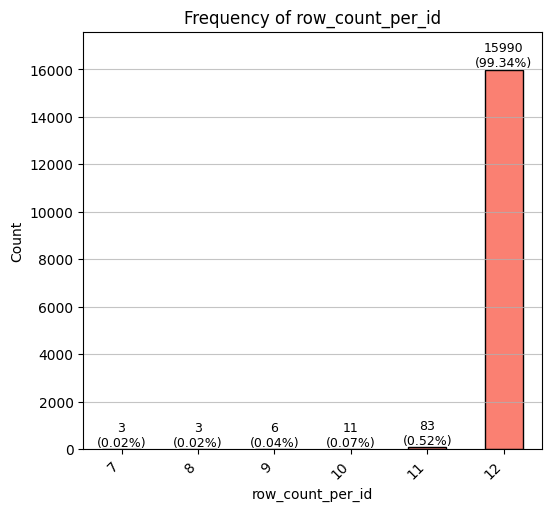

In [36]:
row_counts = price_df.groupby('id').size().reset_index(name='row_count_per_id')

plot_bar_charts(row_counts, ['row_count_per_id'])

Imputing these missing values might be misleading because there might be significantly different price trends for every customer, as can be seen from the following charts that show the trends for the 6 price variables, by plotting both the average trend and the individual trends for a randomly chosen sample of 100 IDs:

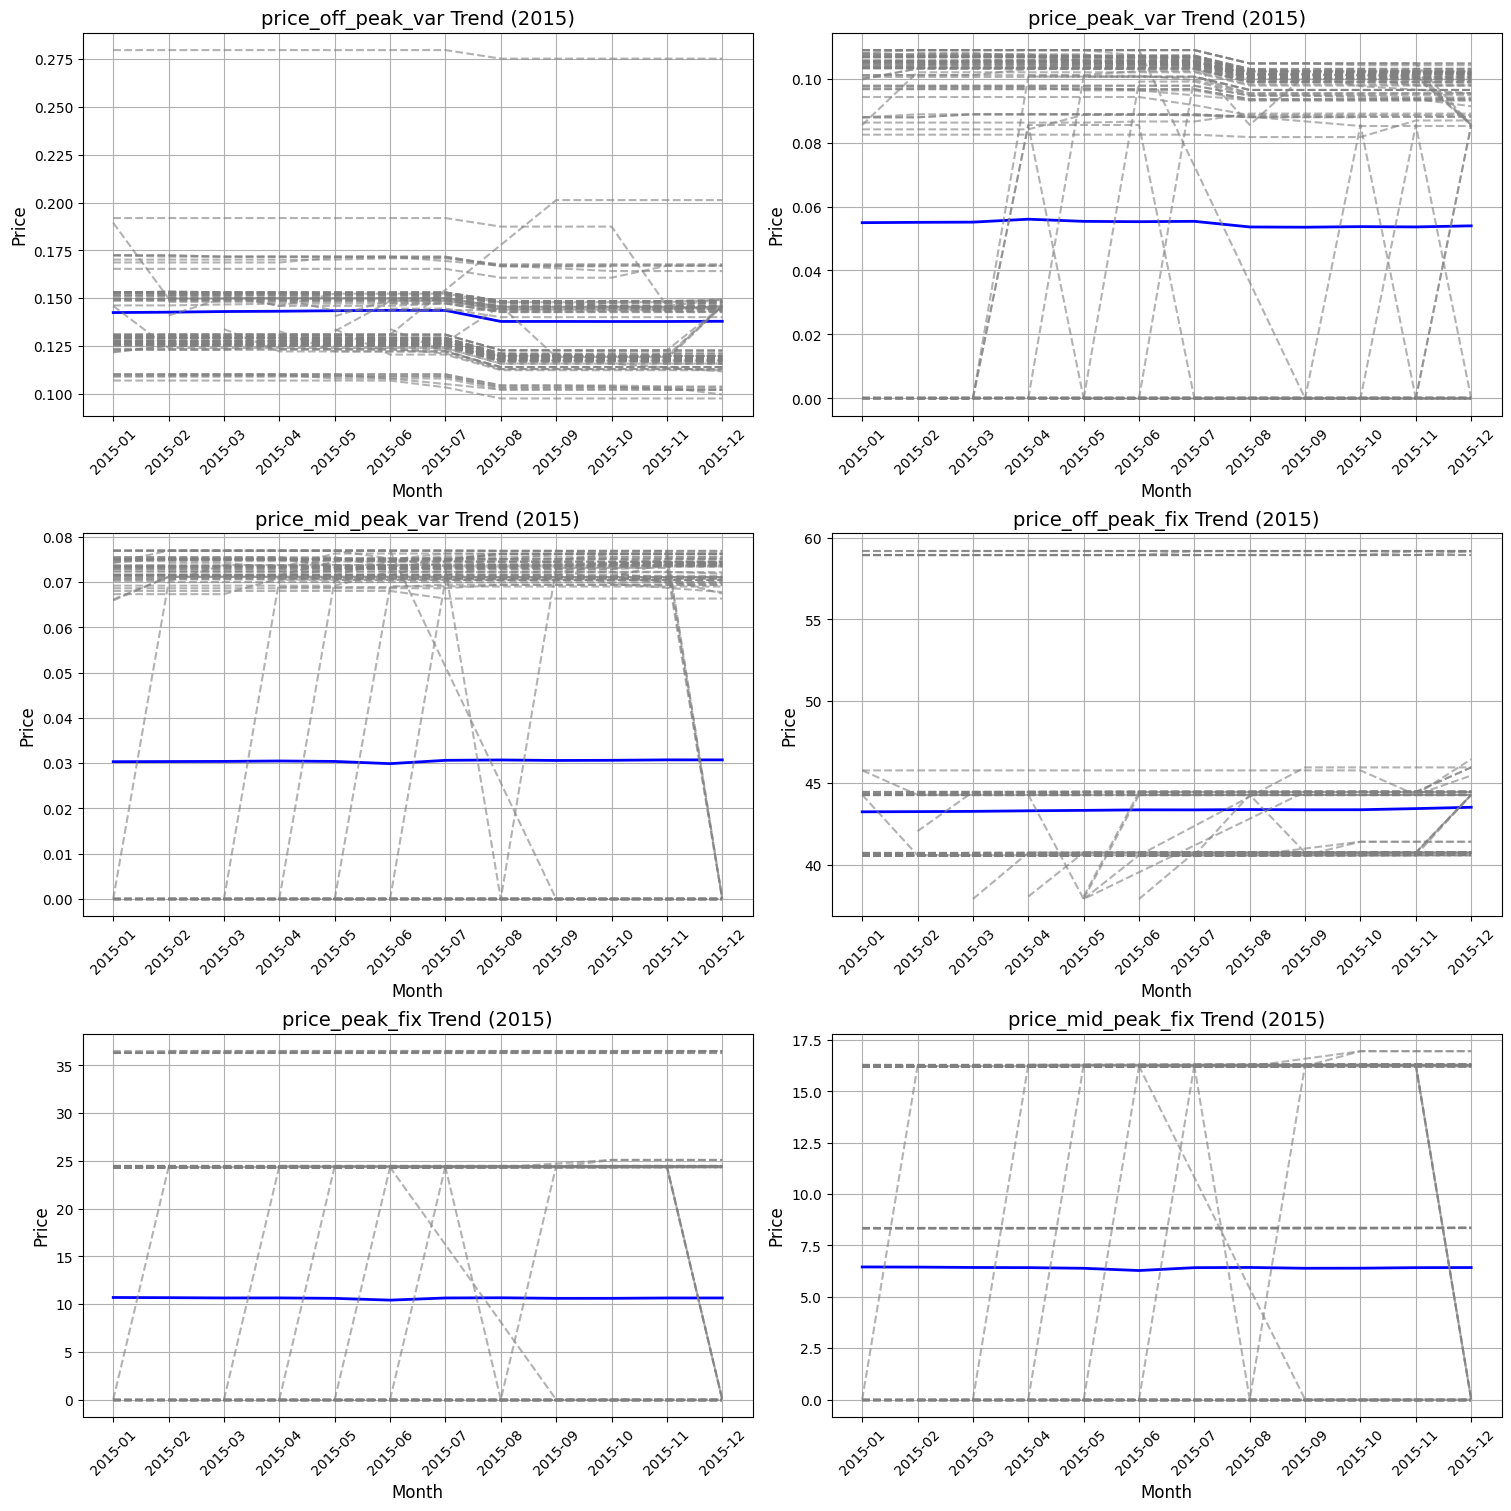

In [37]:
price_numeric_cols = price_df.select_dtypes(include=['number']).columns

plot_price_trends(price_df, price_numeric_cols, price_date_col, 'id', n_sample=100)

As you can see, while many of the individual trends appear as almost constant lines, some show spikes or troughs. For this reason, we could either discard these IDs or retain them as they are. I chose to keep these customers, as there are still enough values available to compute meaningful statistics.

Furthermore, when creating price features from these variables, we will also include features that capture these irregularities in the trends, such as the maximum difference between two consecutive months for each customer.

In [38]:
price_cols = [col for col in price_numeric_cols if col in price_df.columns]
price_df = price_df.sort_values(by=['id', price_date_col])

# Group by 'id'
grouped_df = price_df[['id']+price_cols].groupby('id')

# Compute statistics
mean_df = grouped_df.mean()
min_df = grouped_df.min()
max_df = grouped_df.max()
std_df = grouped_df.std()
max_diff_df = grouped_df.agg(lambda x: max(x.iloc[i+1] - x.iloc[i] for i in range(len(x)-1)))

# Rename columns for clarity
mean_df.columns = [f"{col}_mean" for col in price_cols]
min_df.columns = [f"{col}_min" for col in price_cols]
max_df.columns = [f"{col}_max" for col in price_cols]
std_df.columns = [f"{col}_std" for col in price_cols]
max_diff_df.columns = [f"{col}_max_diff" for col in price_cols]

# Join all DataFrames on 'id'
price_summary_df = pd.concat([mean_df, min_df, max_df, std_df, max_diff_df], axis=1)

# Reset index for a cleaner DataFrame if needed
price_summary_df.reset_index(inplace=True)

price_summary_df

,id,price_off_peak_var_mean,price_peak_var_mean,price_mid_peak_var_mean,price_off_peak_fix_mean,price_peak_fix_mean,price_mid_peak_fix_mean,price_off_peak_var_min,price_peak_var_min,price_mid_peak_var_min,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.119906,0.101673,0.070232,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.143943,0.000000,0.000000,...,0.000000,8.753223e-02,0.000000,0.000000,0.000358,0.000000,0.000000,0.177779,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.150837,0.000000,0.000000,...,0.000000,7.723930e-01,0.000000,0.000000,0.052694,0.000000,0.000000,1.500000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.113068,0.095385,0.068646,...,0.000403,8.507958e-02,0.051048,0.034032,0.000000,0.000000,0.000817,0.162912,0.097752,0.065172
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.145440,0.000000,0.000000,...,0.000000,5.908392e-07,0.000000,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,0.112488,0.094804,0.068829,...,0.012503,1.749923e-01,0.209025,0.226040,0.002317,0.002317,0.002317,0.000000,0.000005,0.000002
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,0.144363,0.000000,0.000000,...,0.000000,8.040373e-02,0.000000,0.000000,0.000684,0.000000,0.000000,0.177780,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,0.151399,0.126871,0.091394,...,0.004310,8.491973e-02,0.051364,0.034586,0.004084,0.002317,0.002317,0.164916,0.099749,0.067166
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,0.118175,0.100491,0.073433,...,0.000471,7.368063e-02,0.044209,0.029474,0.000000,0.000000,0.001083,0.162912,0.097752,0.065172


Before analyzing the distribution of these numeric variables, let's perform an inner join `price_summary_df` with `client_df`:

In [39]:
# Perform an inner join based on 'id'
merged_df = pd.merge(client_df, price_summary_df, on='id', how='inner')

merged_df

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.020983,1.050136e+00,7.039226,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,8.040385e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,8.753223e-02,0.000000,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,Channel 2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,8.040349e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.001588,7.368135e-02,0.044209,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14524,18463073fb097fc0ac5d3e040f356987,Channel 1,32270,47940,0,2012-05-24,2016-05-08,2015-05-08,2014-05-26,4648.01,...,0.000000,9.154352e-02,0.000000,0.000000,0.000569,0.000000,0.000000,0.177780,0.000000,0.000000
14525,d0a6f71671571ed83b2645d23af6de00,Channel 1,7223,0,181,2012-08-27,2016-08-27,2012-08-27,2015-08-28,631.69,...,0.000128,1.165389e-01,0.071868,0.016479,0.000000,0.000000,0.000260,0.236688,0.145968,0.033468
14526,10e6828ddd62cbcf687cb74928c4c2d2,Channel 1,1844,0,179,2012-02-08,2016-02-07,2012-02-08,2015-02-09,190.39,...,0.001368,6.341481e-02,0.038049,0.025366,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166
14527,1cf20fd6206d7678d5bcafd28c53b4db,Channel 1,131,0,0,2012-08-30,2016-08-30,2012-08-30,2015-08-31,19.34,...,0.000000,8.040379e-02,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000


### Analysis of date variables

In [40]:
# 2. Create a table with min and max values for each date variable
datetime_cols = merged_df.select_dtypes(include=['datetime']).columns
date_summary = merged_df[datetime_cols].agg(['min', 'max']).transpose()
date_summary.columns = ['Minimum Date', 'Maximum Date']

# Display the results
print("Date Summary Table:")
date_summary

Date Summary Table:


,Minimum Date,Maximum Date
date_activ,2003-05-09,2014-09-01
date_end,2016-01-28,2017-06-13
date_modif_prod,2003-05-09,2016-01-29
date_renewal,2013-06-26,2016-01-28


Before removing the date variables from the dataset, let's create some features out of them:
- `product_modified`: this variable can take value 0 or 1, depending on whether `date_modif_prod` is equal to `date_activ` or not, respectively. **CONVERT TO OBJECT!**
- `days_to_end`: this variable computes the number of days between the end of the historical period (December 31, 2015) and the registered date of the end of the contract.

In [41]:
# Compute 'product_modified'
merged_df.loc[:, 'product_modified'] = (merged_df['date_modif_prod'] > merged_df['date_activ']).astype(int).astype('object')
merged_df.loc[:, 'product_modified'] = merged_df['product_modified'].map({0: 'No', 1: 'Yes'})

# Compute 'days_to_end'
historical_end_date = pd.Timestamp('2015-12-31')
merged_df.loc[:, 'days_to_end'] = (merged_df['date_end'] - historical_end_date).dt.days

merged_df[['date_activ', 'date_modif_prod', 'product_modified', 'date_end', 'days_to_end']].head(10)

,date_activ,date_modif_prod,product_modified,date_end,days_to_end
0,2013-06-15,2015-11-01,Yes,2016-06-15,167
1,2009-08-21,2009-08-21,No,2016-08-30,243
2,2010-04-16,2010-04-16,No,2016-04-16,107
3,2010-03-30,2010-03-30,No,2016-03-30,90
4,2010-01-13,2010-01-13,No,2016-03-07,67
5,2011-12-09,2015-11-01,Yes,2016-12-09,344
6,2011-12-02,2011-12-02,No,2016-12-02,337
7,2010-04-21,2010-04-21,No,2016-04-21,112
8,2011-09-23,2011-09-23,No,2016-09-23,267
9,2010-05-04,2015-04-29,Yes,2016-05-04,125


In [42]:
merged_df.drop(datetime_cols, axis=1, inplace=True)

### Saving the first version of the dataset

Before performing additional data transformations and feature engineerings on the numeric and categorical variables, it has been decided to save the current version of the dataset, in order to assess if the subsequent data preparation steps really enhance model performance.

In [43]:
merged_df.to_csv(f"{repo_path}/data/merged_data_no_tfm.csv", index=False)

### Analysis of Numeric variables

Let's begin analyzing the numeric variables by plotting the **correlation matrix**, displaying only cells with a correlation greater than 0.9:

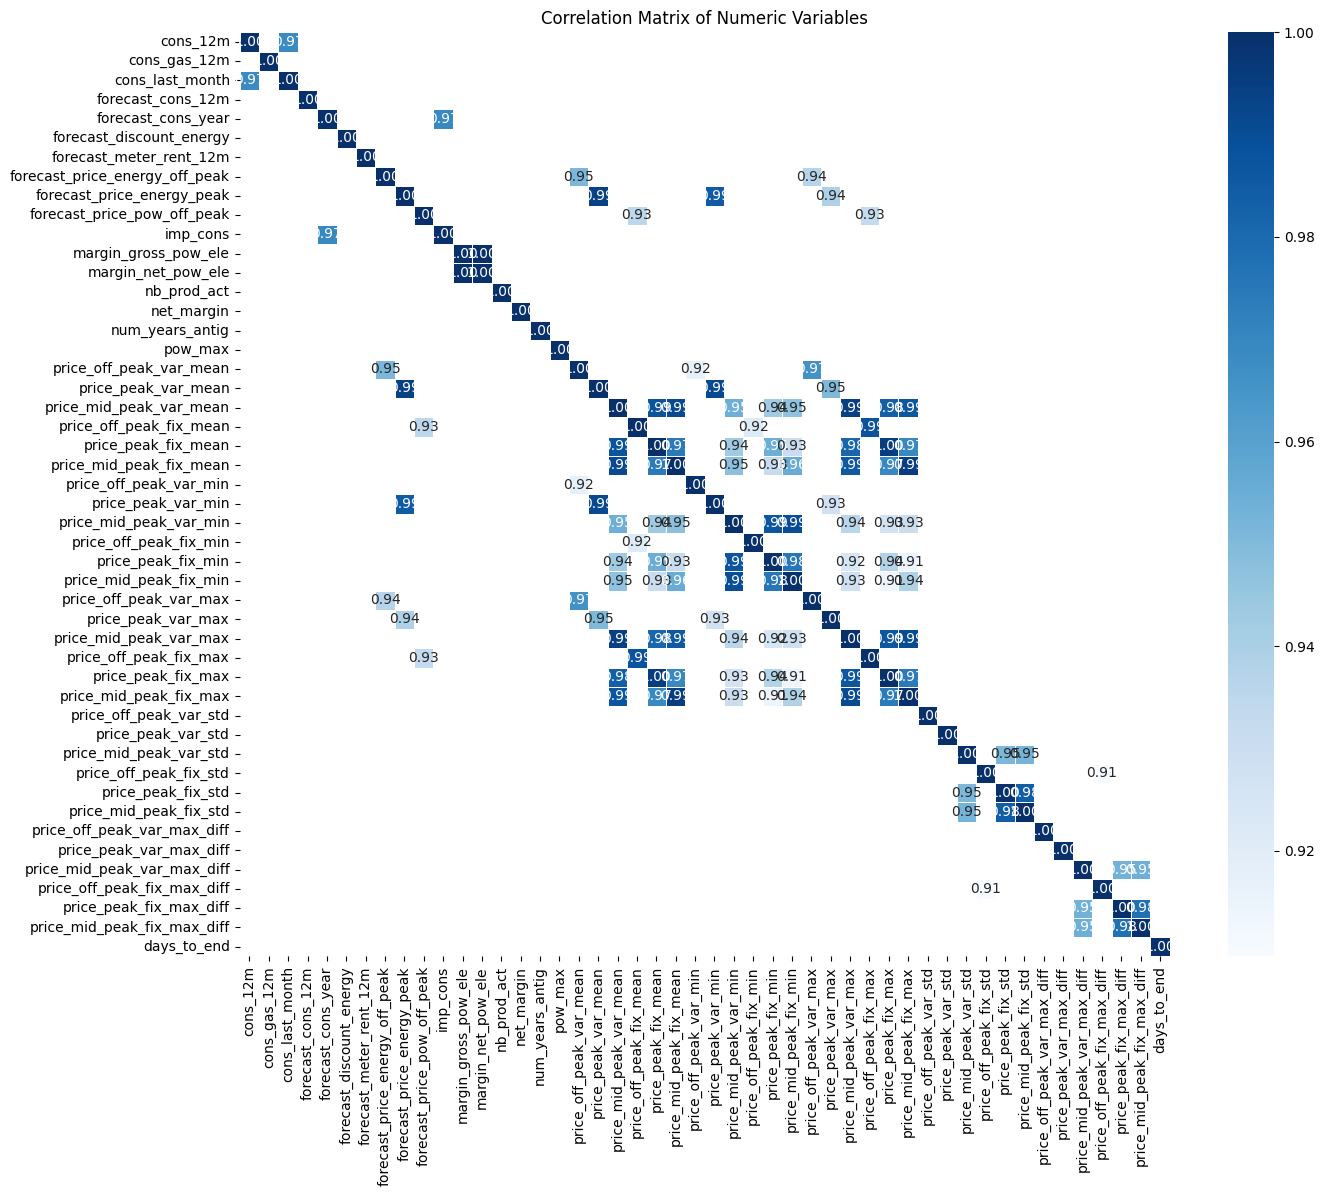

In [44]:
high_corr_pairs = plot_correlation_matrix(merged_df, merged_df.select_dtypes(include='number').columns)

In [45]:
high_corr_pairs.sort_values(by="correlation", ascending=False)

,variable_1,variable_2,correlation
462,margin_gross_pow_ele,margin_net_pow_ele,0.999913
788,price_peak_fix_mean,price_peak_fix_max,0.995308
814,price_mid_peak_fix_mean,price_mid_peak_fix_max,0.994977
733,price_mid_peak_var_mean,price_mid_peak_var_max,0.994531
357,forecast_price_energy_peak,price_peak_var_mean,0.994020
724,price_mid_peak_var_mean,price_mid_peak_fix_mean,0.991504
698,price_peak_var_mean,price_peak_var_min,0.991290
994,price_mid_peak_var_max,price_mid_peak_fix_max,0.990589
877,price_mid_peak_var_min,price_mid_peak_fix_min,0.989917
761,price_off_peak_fix_mean,price_off_peak_fix_max,0.987696


As you can see, several pairs of variables are highly correlated (correlation greater than 0.9). Since they convey nearly the same information, I will retain only one variable from each pair, specifically the distinct variables in the `variable_2` column.

In [46]:
merged_df.drop(high_corr_pairs['variable_1'].unique(), axis=1, inplace=True)

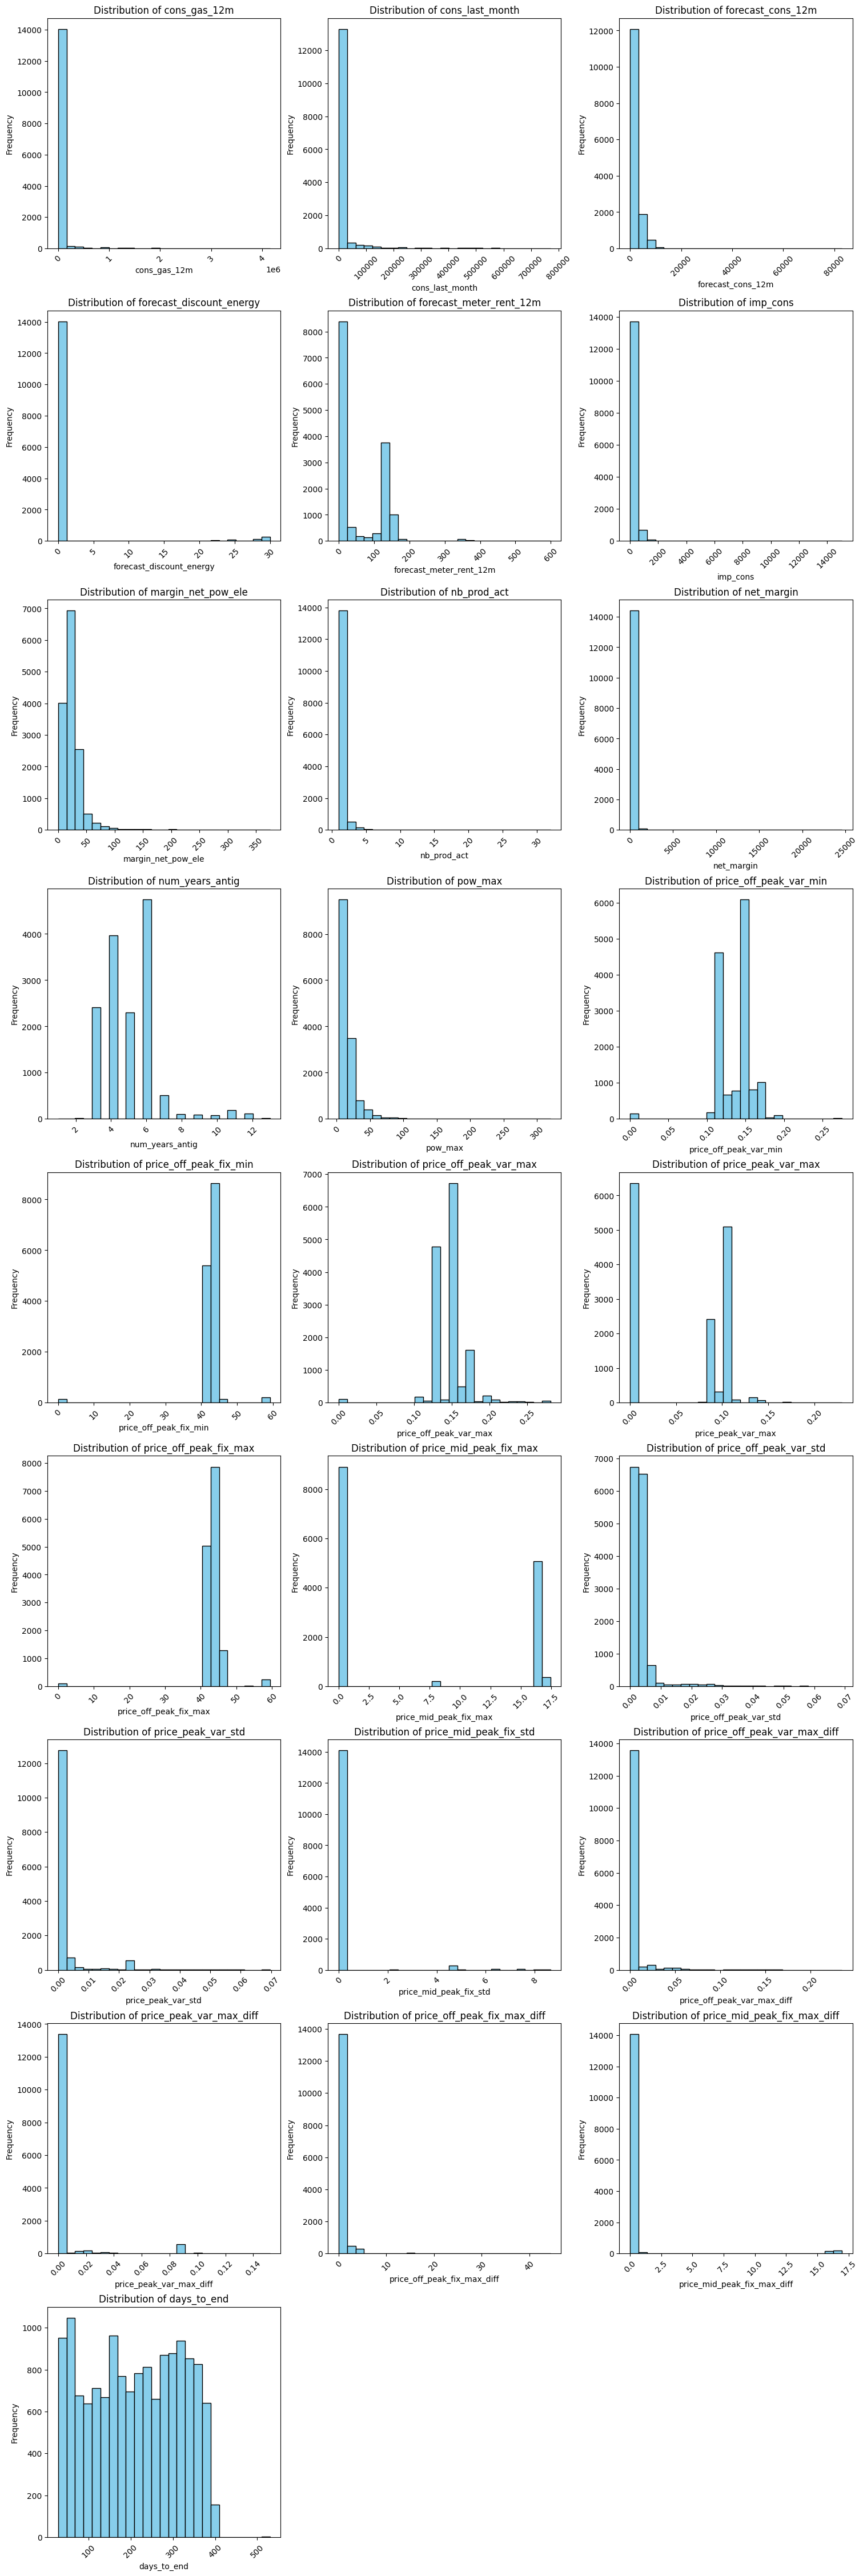

In [47]:
numeric_cols = merged_df.select_dtypes(include='number').columns

plot_numeric_distributions(merged_df, numeric_cols)

As we can see, there are many extremely skewed predictors. This can be problematic because the number of observations available to predict the target varies greatly across the range of the input values. To have a better understanding of the problem, let's first compute skewness, number of 0s, and cardinality for each of the numeric columns:

In [48]:
num_stats_df = compute_and_sort_statistics(merged_df, numeric_cols, by='cardinality', ascending=True)
num_stats_df

,skewness,zero_counts,cardinality
nb_prod_act,8.665068,0,10
forecast_discount_energy,5.145705,14018,12
num_years_antig,1.448207,0,13
price_mid_peak_fix_max,0.493465,8909,15
price_off_peak_fix_min,-5.739459,139,30
price_off_peak_fix_max,-5.252087,105,39
price_mid_peak_fix_max_diff,6.164334,10322,39
price_off_peak_fix_max_diff,15.524186,3172,111
price_peak_var_max,-0.161301,6357,313
days_to_end,-0.042398,0,368


Let's focus on the first 4 variables of the table above (`forecast_discount_energy`, `nb_prod_act` and `num_years_antig`) and plot their value frequencies:

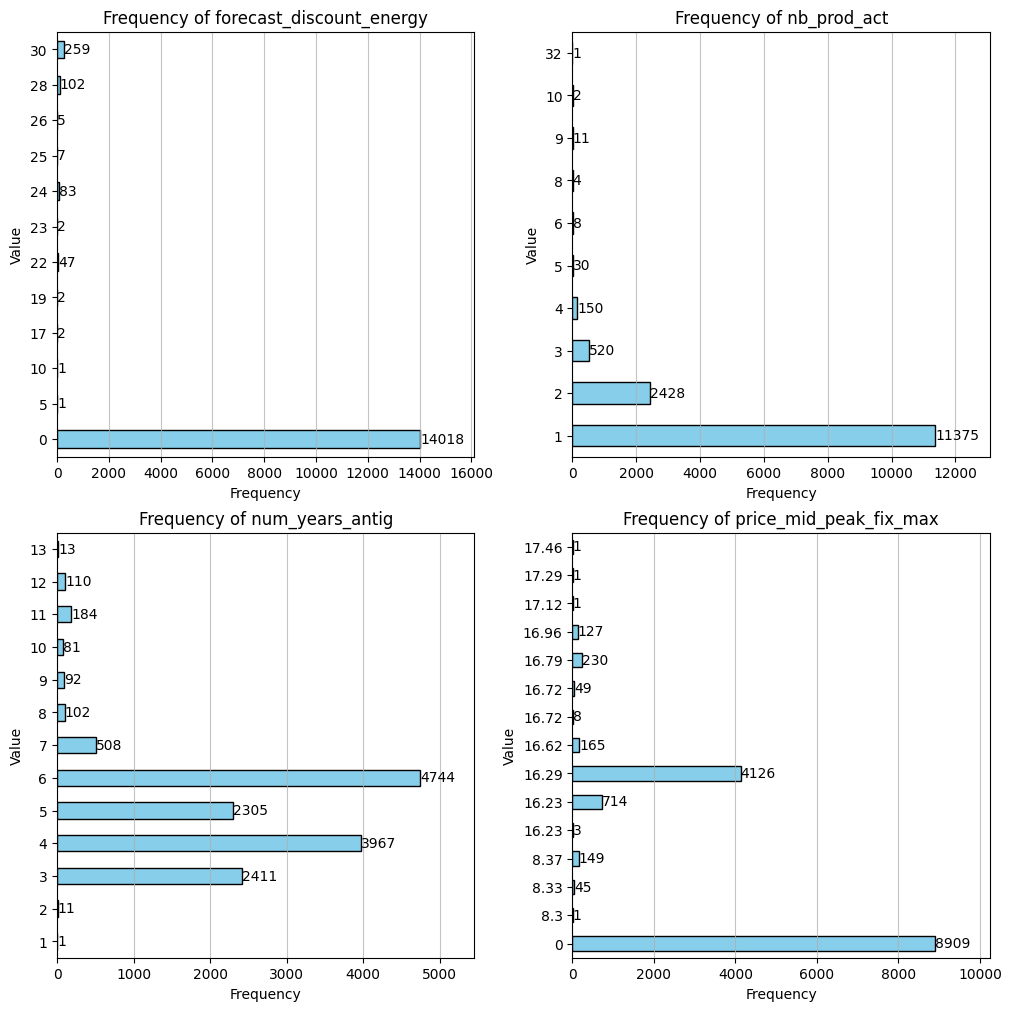

In [49]:
low_cardinality_cols = [col for col in numeric_cols if num_stats_df.loc[col, 'cardinality']<=15]

plot_bar_charts(merged_df, low_cardinality_cols, orientation='horizontal')

For these 4 variables, I decided to create the following categorical variables to group rare values and see if this might be helpful in reducing overfit and generalize better on unseen data:
- `nb_prod_act`: 3 categories: '1', '2' and '3 or more'
- `num_years_antig`: 5 categories: '3 or less', '4', '5', '6' and '7 or more'
- `forecast_discount_energy`: in this case, since less than 4% of the data has a value different than 0, I decided to just create a flag with values '0' and '>0'
- `price_mid_peak_fix_max`: There appear to be three distinct sets of values: '0', '>0 and <12', and '>12'. The value 12 has been chosen as the split point because it lies between the two peaks around 8 and 16.

In [54]:
# Transformation for `nb_prod_act`
merged_df['nb_prod_act_cat'] = np.where(merged_df['nb_prod_act'] >= 3, '3 or more',
                                        merged_df['nb_prod_act'].astype(str))

# Transformation for `num_years_antig`
merged_df['num_years_antig_cat'] = np.where(merged_df['num_years_antig'] <= 3, '3 or less',
                                        np.where(merged_df['num_years_antig'] == 4, '4',
                                                np.where(merged_df['num_years_antig'] == 5, '5',
                                                        np.where(merged_df['num_years_antig'] == 6, '6', '7 or more'))))

# Transformation for `forecast_discount_energy`
merged_df['is_zero_forecast_discount_energy'] = np.where(merged_df['forecast_discount_energy'] > 0, 'No', 'Yes')

# Transformation for `price_mid_peak_fix_max`
merged_df['price_mid_peak_fix_max_cat'] = np.where(merged_df['price_mid_peak_fix_max'] == 0, '0',
                                            np.where(merged_df['price_mid_peak_fix_max'] <= 12, '>0 and <=12', '>12'))

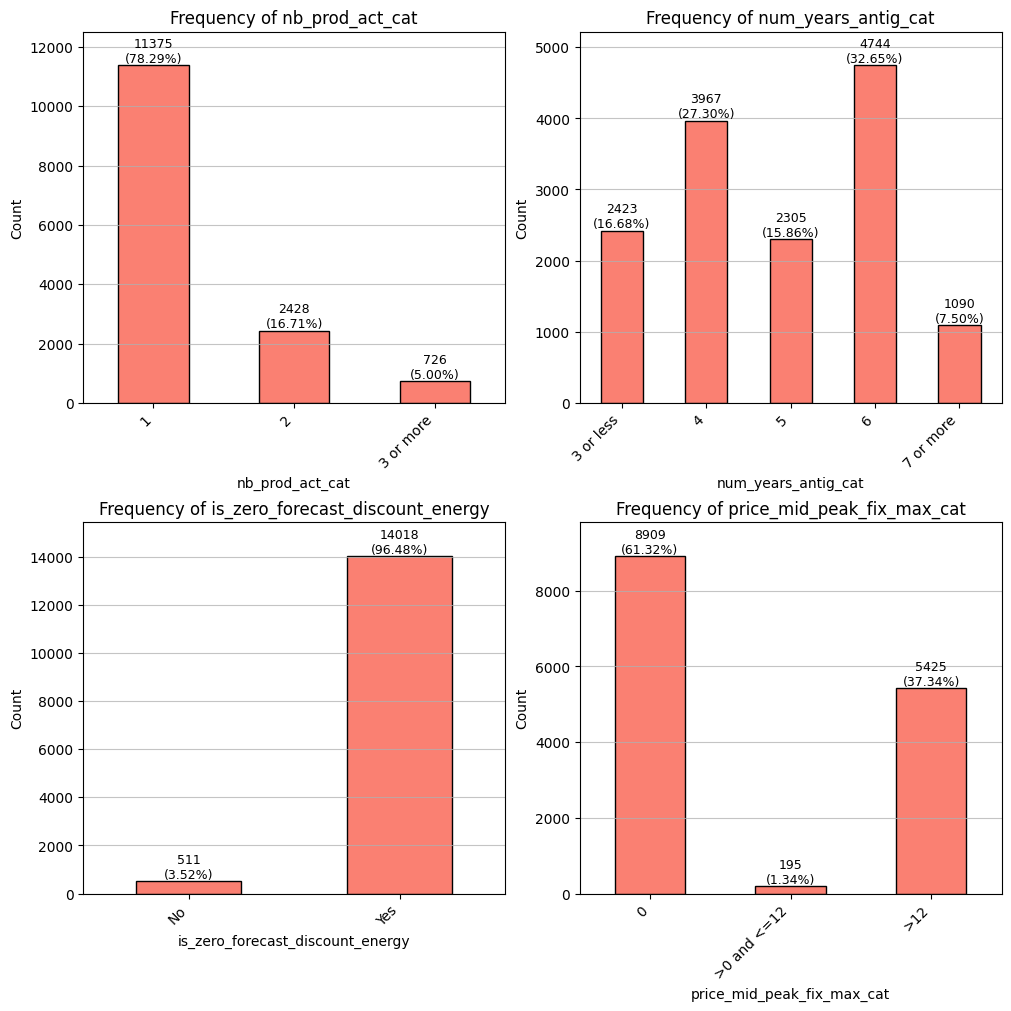

In [55]:
categorized_cols = ['nb_prod_act_cat', 'num_years_antig_cat', 'is_zero_forecast_discount_energy', 'price_mid_peak_fix_max_cat']

plot_bar_charts(merged_df, categorized_cols, orientation='vertical')

In [56]:
merged_df.drop(low_cardinality_cols, axis=1, inplace=True)

Let's now focus on the remaining numeric variables:

In [57]:
num_stats_df = num_stats_df[num_stats_df['cardinality']>15].sort_values(by='zero_counts', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
cons_gas_12m,9.640002,11975,2059
price_mid_peak_fix_max_diff,6.164334,10322,39
price_mid_peak_fix_std,6.063255,9658,370
price_peak_var_max_diff,4.143847,8229,939
price_peak_var_max,-0.161301,6357,313
price_peak_var_std,4.314246,6357,2687
imp_cons,13.183958,6124,7728
price_off_peak_var_max_diff,6.794844,5340,1364
cons_last_month,6.374610,4946,4740
price_off_peak_fix_max_diff,15.524186,3172,111


There are several columns with many rows having value 0. Let's see the distributions of the variables with more than 30% of 0 values when removing all these 0 rows:

Skewness for column cons_gas_12m (excluding zeros): 3.912
---------------------------------
Skewness for column price_mid_peak_fix_max_diff (excluding zeros): 2.996
---------------------------------
Skewness for column price_mid_peak_fix_std (excluding zeros): 3.234
---------------------------------
Skewness for column price_peak_var_max_diff (excluding zeros): 2.448
---------------------------------
Skewness for column price_peak_var_max (excluding zeros): 1.115
---------------------------------
Skewness for column price_peak_var_std (excluding zeros): 3.239
---------------------------------
Skewness for column imp_cons (excluding zeros): 11.923
---------------------------------
Skewness for column price_off_peak_var_max_diff (excluding zeros): 5.405
---------------------------------
Skewness for column cons_last_month (excluding zeros): 5.122
---------------------------------


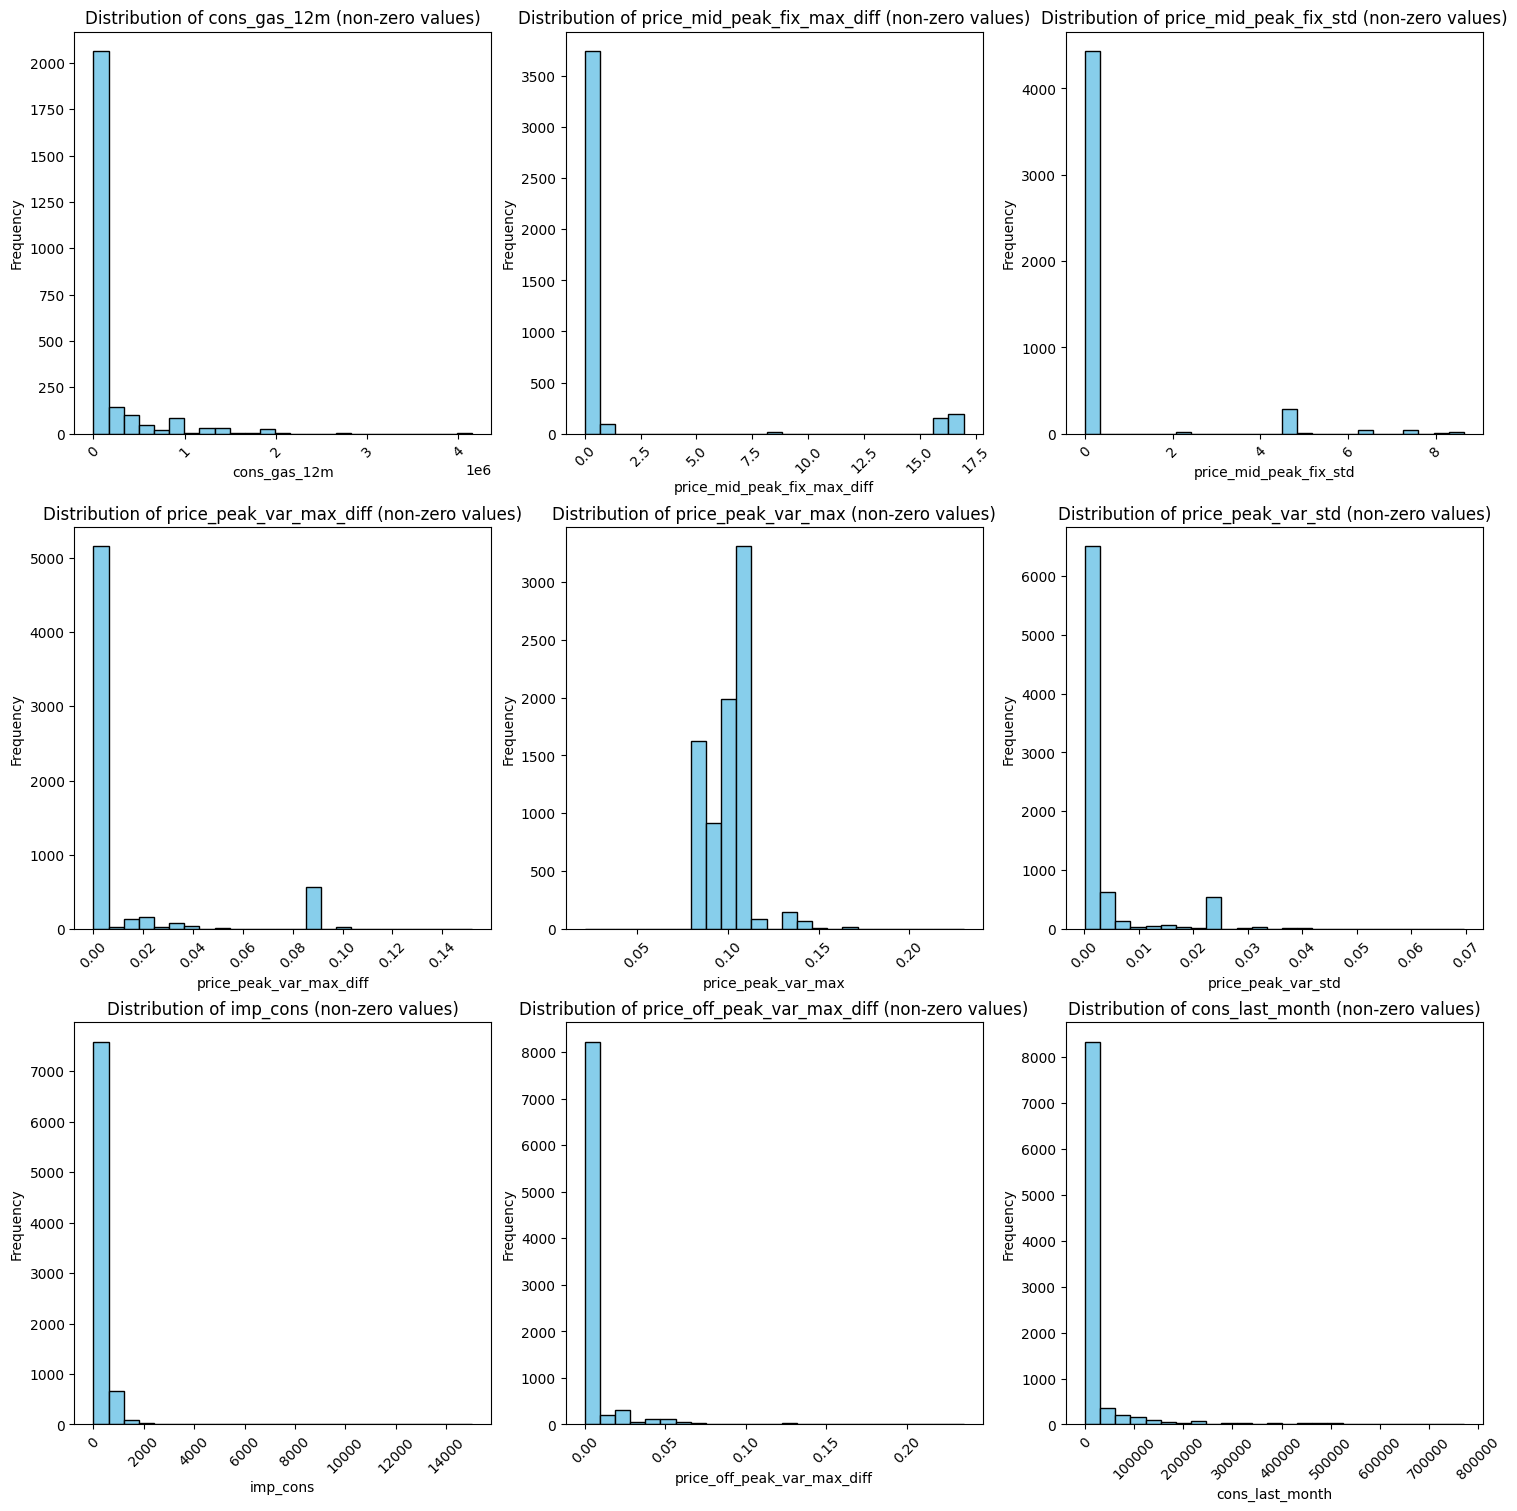

In [58]:
numeric_cols = [col for col in num_stats_df.index]

plot_histograms_for_sparse_cols(merged_df, numeric_cols, zero_threshold=0.3)

Some of these distributions remain highly skewed even when removing the 0 values. For all these variables, we can consider to build:
- a flag indicator telling whether the variable is in the spike (0 value) or in the distribution (non-zero value).
- a variable created from the values of the original one in the distribution and where the observations that have the value at the spike are set to missing. A log transformation is then performed on the non-missing values of this variable (except for the variables whose skewness is less than 3 when removing the 0 rows), while missing values will be imputed during the Model Building phase.



- **TO REMOVE!** perform a log transformation on the values of the distribution (except for the variables whose skewness is less than 3 when removing the 0 rows), and afterwards replacing zero values with the value minimizing the impact on the relationship between the predictor and the response, estimated by the **Point-Biserial correlation coefficient**. The log transformation is performed to decrease the skewness and generate a more consistent support across the range of values.

In [59]:
many_zeros_cols = [col for col in num_stats_df.index if num_stats_df.loc[col,'zero_counts']>0.3*len(merged_df)]

#merged_df, skewness, distr_transformed_cols = apply_log_transformation_and_impute(merged_df, many_zeros_cols, skewness_threshold=3.0, target='churn')
merged_df, distr_transformed_cols = engineer_saz_features(merged_df, many_zeros_cols, skewness_threshold=3.0, target='churn')

Skewness for column cons_gas_12m_log: -0.181
---------------------------------
Skewness for column price_mid_peak_fix_max_diff_distr: 2.996
---------------------------------
Skewness for column price_mid_peak_fix_std_log: 2.904
---------------------------------
Skewness for column price_peak_var_max_diff_distr: 2.448
---------------------------------
Skewness for column price_peak_var_max_distr: 1.115
---------------------------------
Skewness for column price_peak_var_std_log: 3.205
---------------------------------
Skewness for column imp_cons_log: -0.752
---------------------------------
Skewness for column price_off_peak_var_max_diff_log: 5.209
---------------------------------
Skewness for column cons_last_month_log: 0.435
---------------------------------


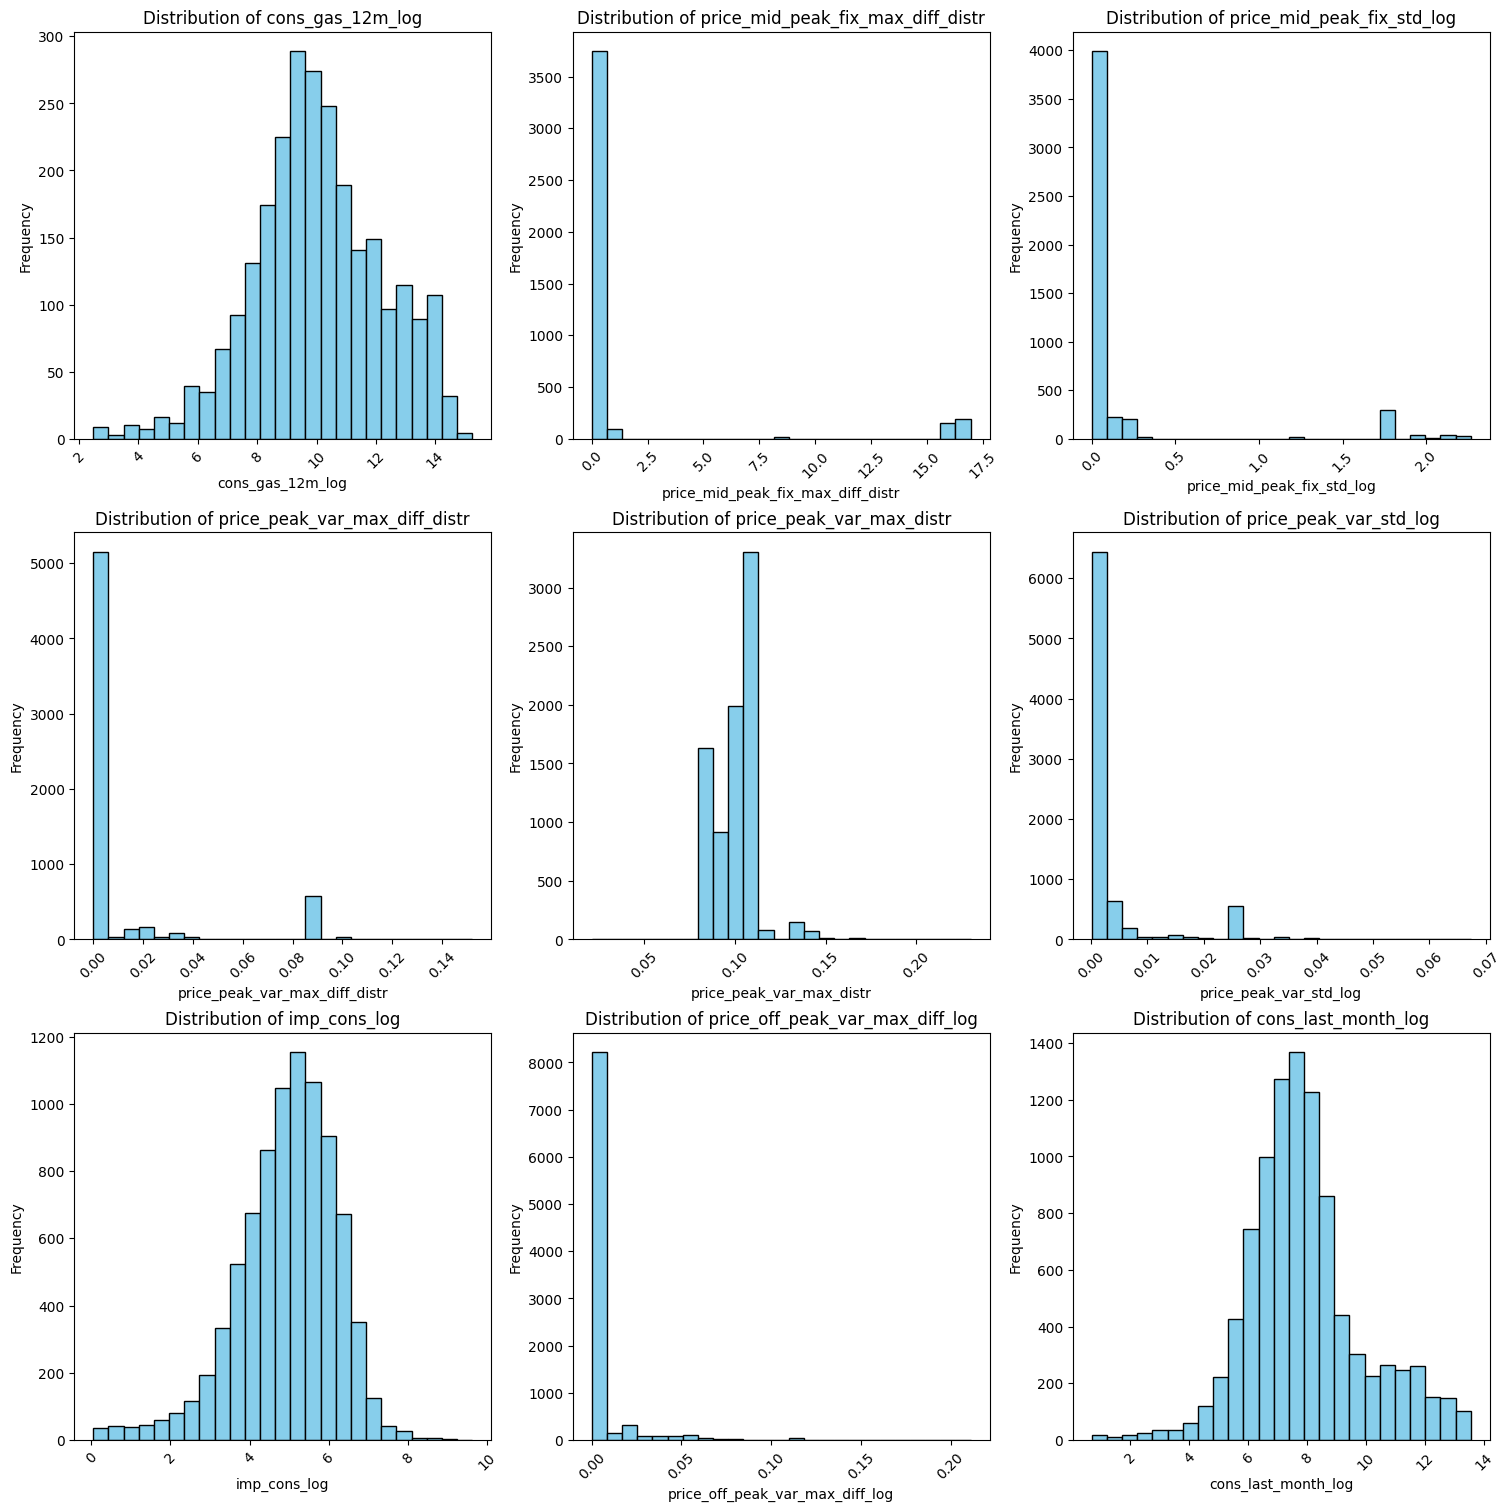

In [60]:
for i, col in enumerate(distr_transformed_cols):
    col_skewness = merged_df[col].skew()
    print(f'Skewness for column {col}: {col_skewness:.3f}')
    print('---------------------------------')

plot_numeric_distributions(merged_df, distr_transformed_cols)

In [61]:
merged_df.drop(many_zeros_cols, axis=1, inplace=True)

In [62]:
num_stats_df = num_stats_df[num_stats_df['zero_counts']<=0.3*len(merged_df)].sort_values(by='skewness', ascending=False)
num_stats_df

,skewness,zero_counts,cardinality
net_margin,36.540197,184,11917
price_off_peak_fix_max_diff,15.524186,3172,111
forecast_cons_12m,7.153735,305,13922
price_off_peak_var_std,6.455391,100,4655
pow_max,5.787936,0,693
margin_net_pow_ele,4.475705,157,2381
forecast_meter_rent_12m,1.507597,722,3512
days_to_end,-0.042398,0,368
price_off_peak_var_max,-0.458833,20,498
price_off_peak_var_min,-1.682037,65,675


Finally, I decided to apply a log transformation to all remaining variables with a skewness greater than 3 and a square transformation to all remaining variables with a skewness lower than -3. This was done to achieve a more consistent distribution across their range of values, for the same reasons mentioned earlier.

In [63]:
skewness = num_stats_df['skewness']
cols_to_transform = [col for col in num_stats_df.index if abs(skewness[col])>3]
transformed_cols = []

for col in cols_to_transform:
    if skewness[col]<0:
        col_name = f"{col}_square"
        merged_df[col_name] = merged_df[col].apply(lambda x: x**2)
    elif skewness[col]>0:
        col_name = f"{col}_log"
        merged_df[col_name] = merged_df[col].apply(lambda x: np.log1p(x))

    transformed_cols.append(col_name)

# Print the transformed columns
print(f"Transformed columns: {cols_to_transform}")

Transformed columns: ['net_margin', 'price_off_peak_fix_max_diff', 'forecast_cons_12m', 'price_off_peak_var_std', 'pow_max', 'margin_net_pow_ele', 'price_off_peak_fix_max', 'price_off_peak_fix_min']


Skewness for column net_margin_log: -0.968
---------------------------------
Skewness for column price_off_peak_fix_max_diff_log: 3.742
---------------------------------
Skewness for column forecast_cons_12m_log: -2.034
---------------------------------
Skewness for column price_off_peak_var_std_log: 6.363
---------------------------------
Skewness for column pow_max_log: 1.805
---------------------------------
Skewness for column margin_net_pow_ele_log: -1.310
---------------------------------
Skewness for column price_off_peak_fix_max_square: 0.619
---------------------------------
Skewness for column price_off_peak_fix_min_square: -0.129
---------------------------------


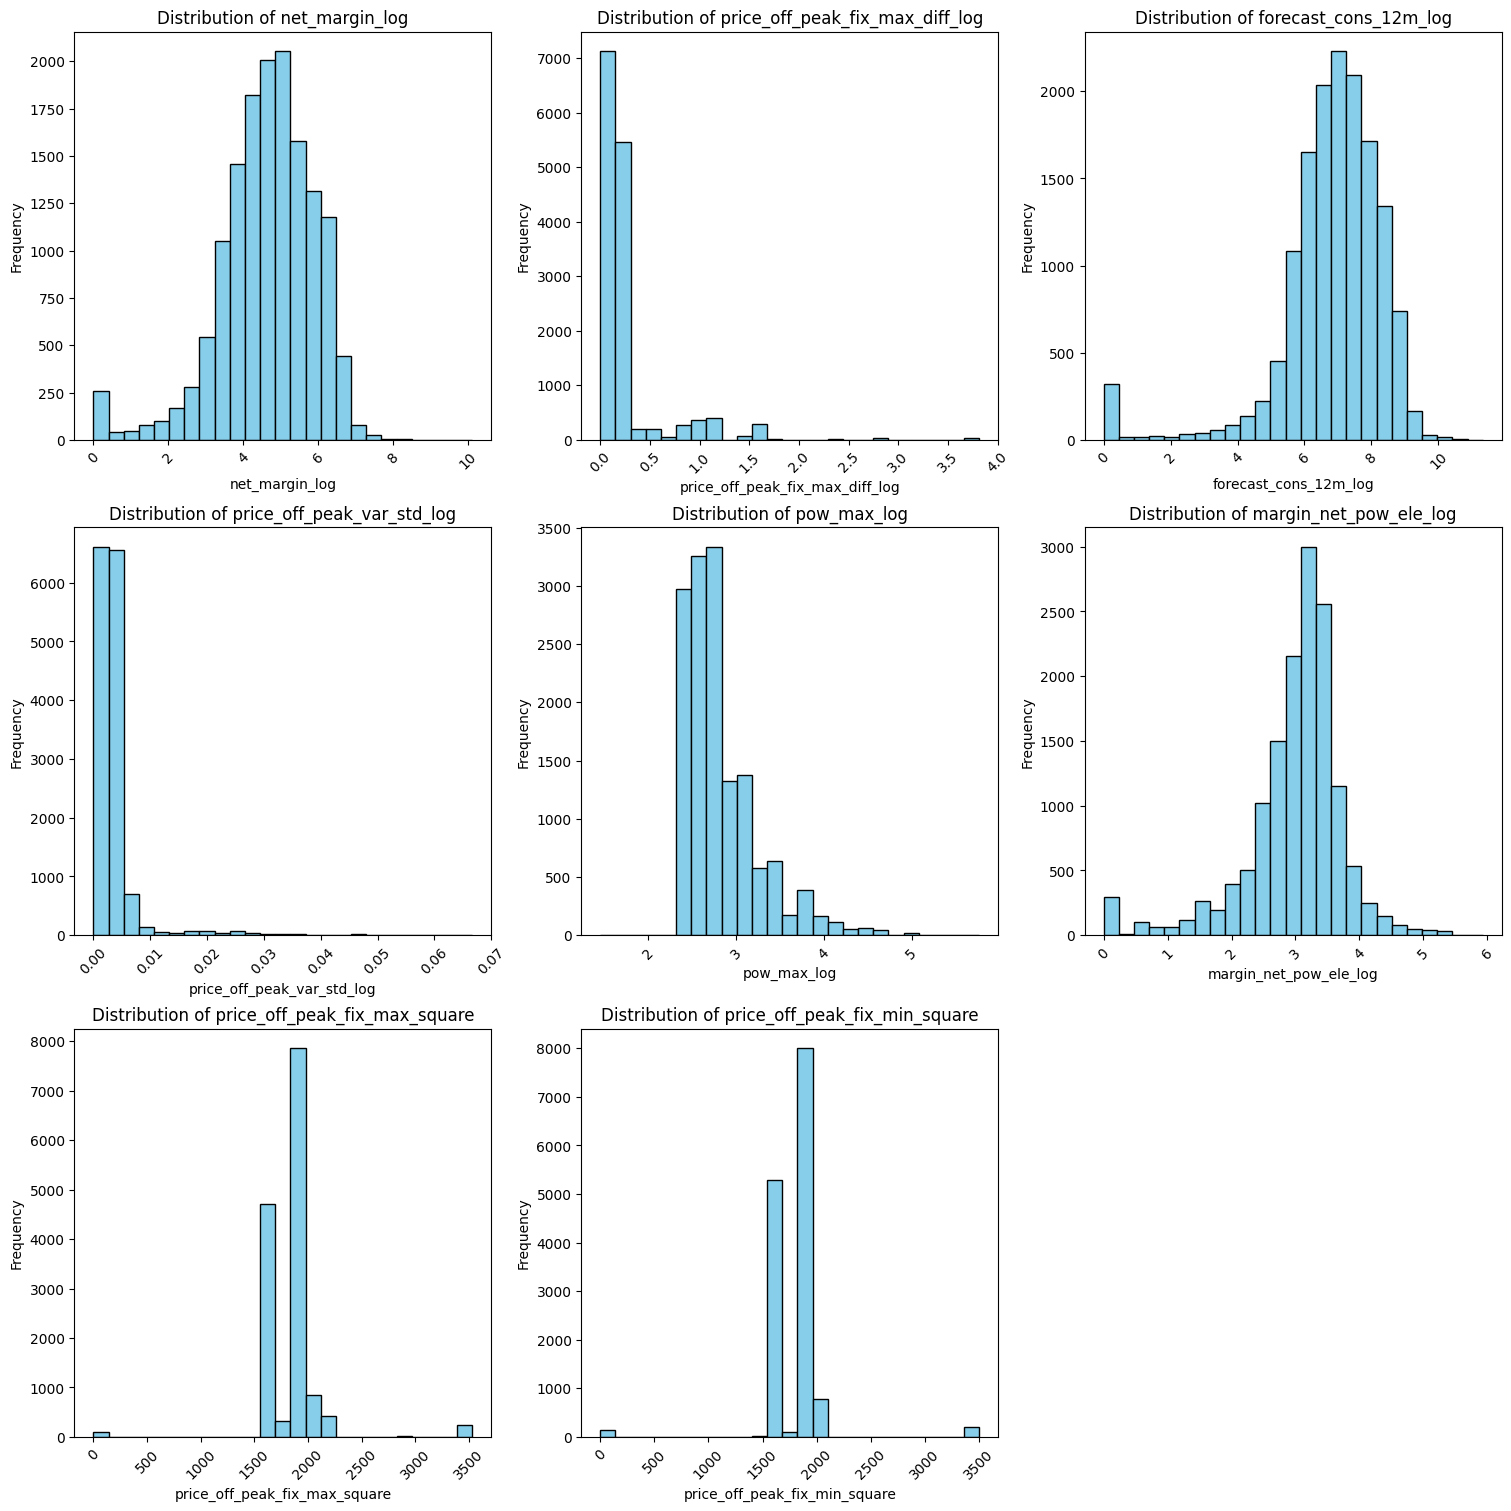

In [64]:
for i, col in enumerate(transformed_cols):
    col_skewness = merged_df[col].skew()
    print(f'Skewness for column {col}: {col_skewness:.3f}')
    print('---------------------------------')

plot_numeric_distributions(merged_df, transformed_cols)

In [65]:
merged_df.drop(cols_to_transform, axis=1, inplace=True)

Let's now conclude the data preparation phase by examining the categorical variables.

### Categorical variables

In [66]:
categorical_cols = [col for col in merged_df.select_dtypes(exclude='number').columns if col!='id']
categorical_cols

['channel_sales',
 'has_gas',
 'origin_up',
 'churn',
 'product_modified',
 'nb_prod_act_cat',
 'num_years_antig_cat',
 'is_zero_forecast_discount_energy',
 'price_mid_peak_fix_max_cat',
 'is_zero_cons_gas_12m',
 'is_zero_price_mid_peak_fix_max_diff',
 'is_zero_price_mid_peak_fix_std',
 'is_zero_price_peak_var_max_diff',
 'is_zero_price_peak_var_max',
 'is_zero_price_peak_var_std',
 'is_zero_imp_cons',
 'is_zero_price_off_peak_var_max_diff',
 'is_zero_cons_last_month']

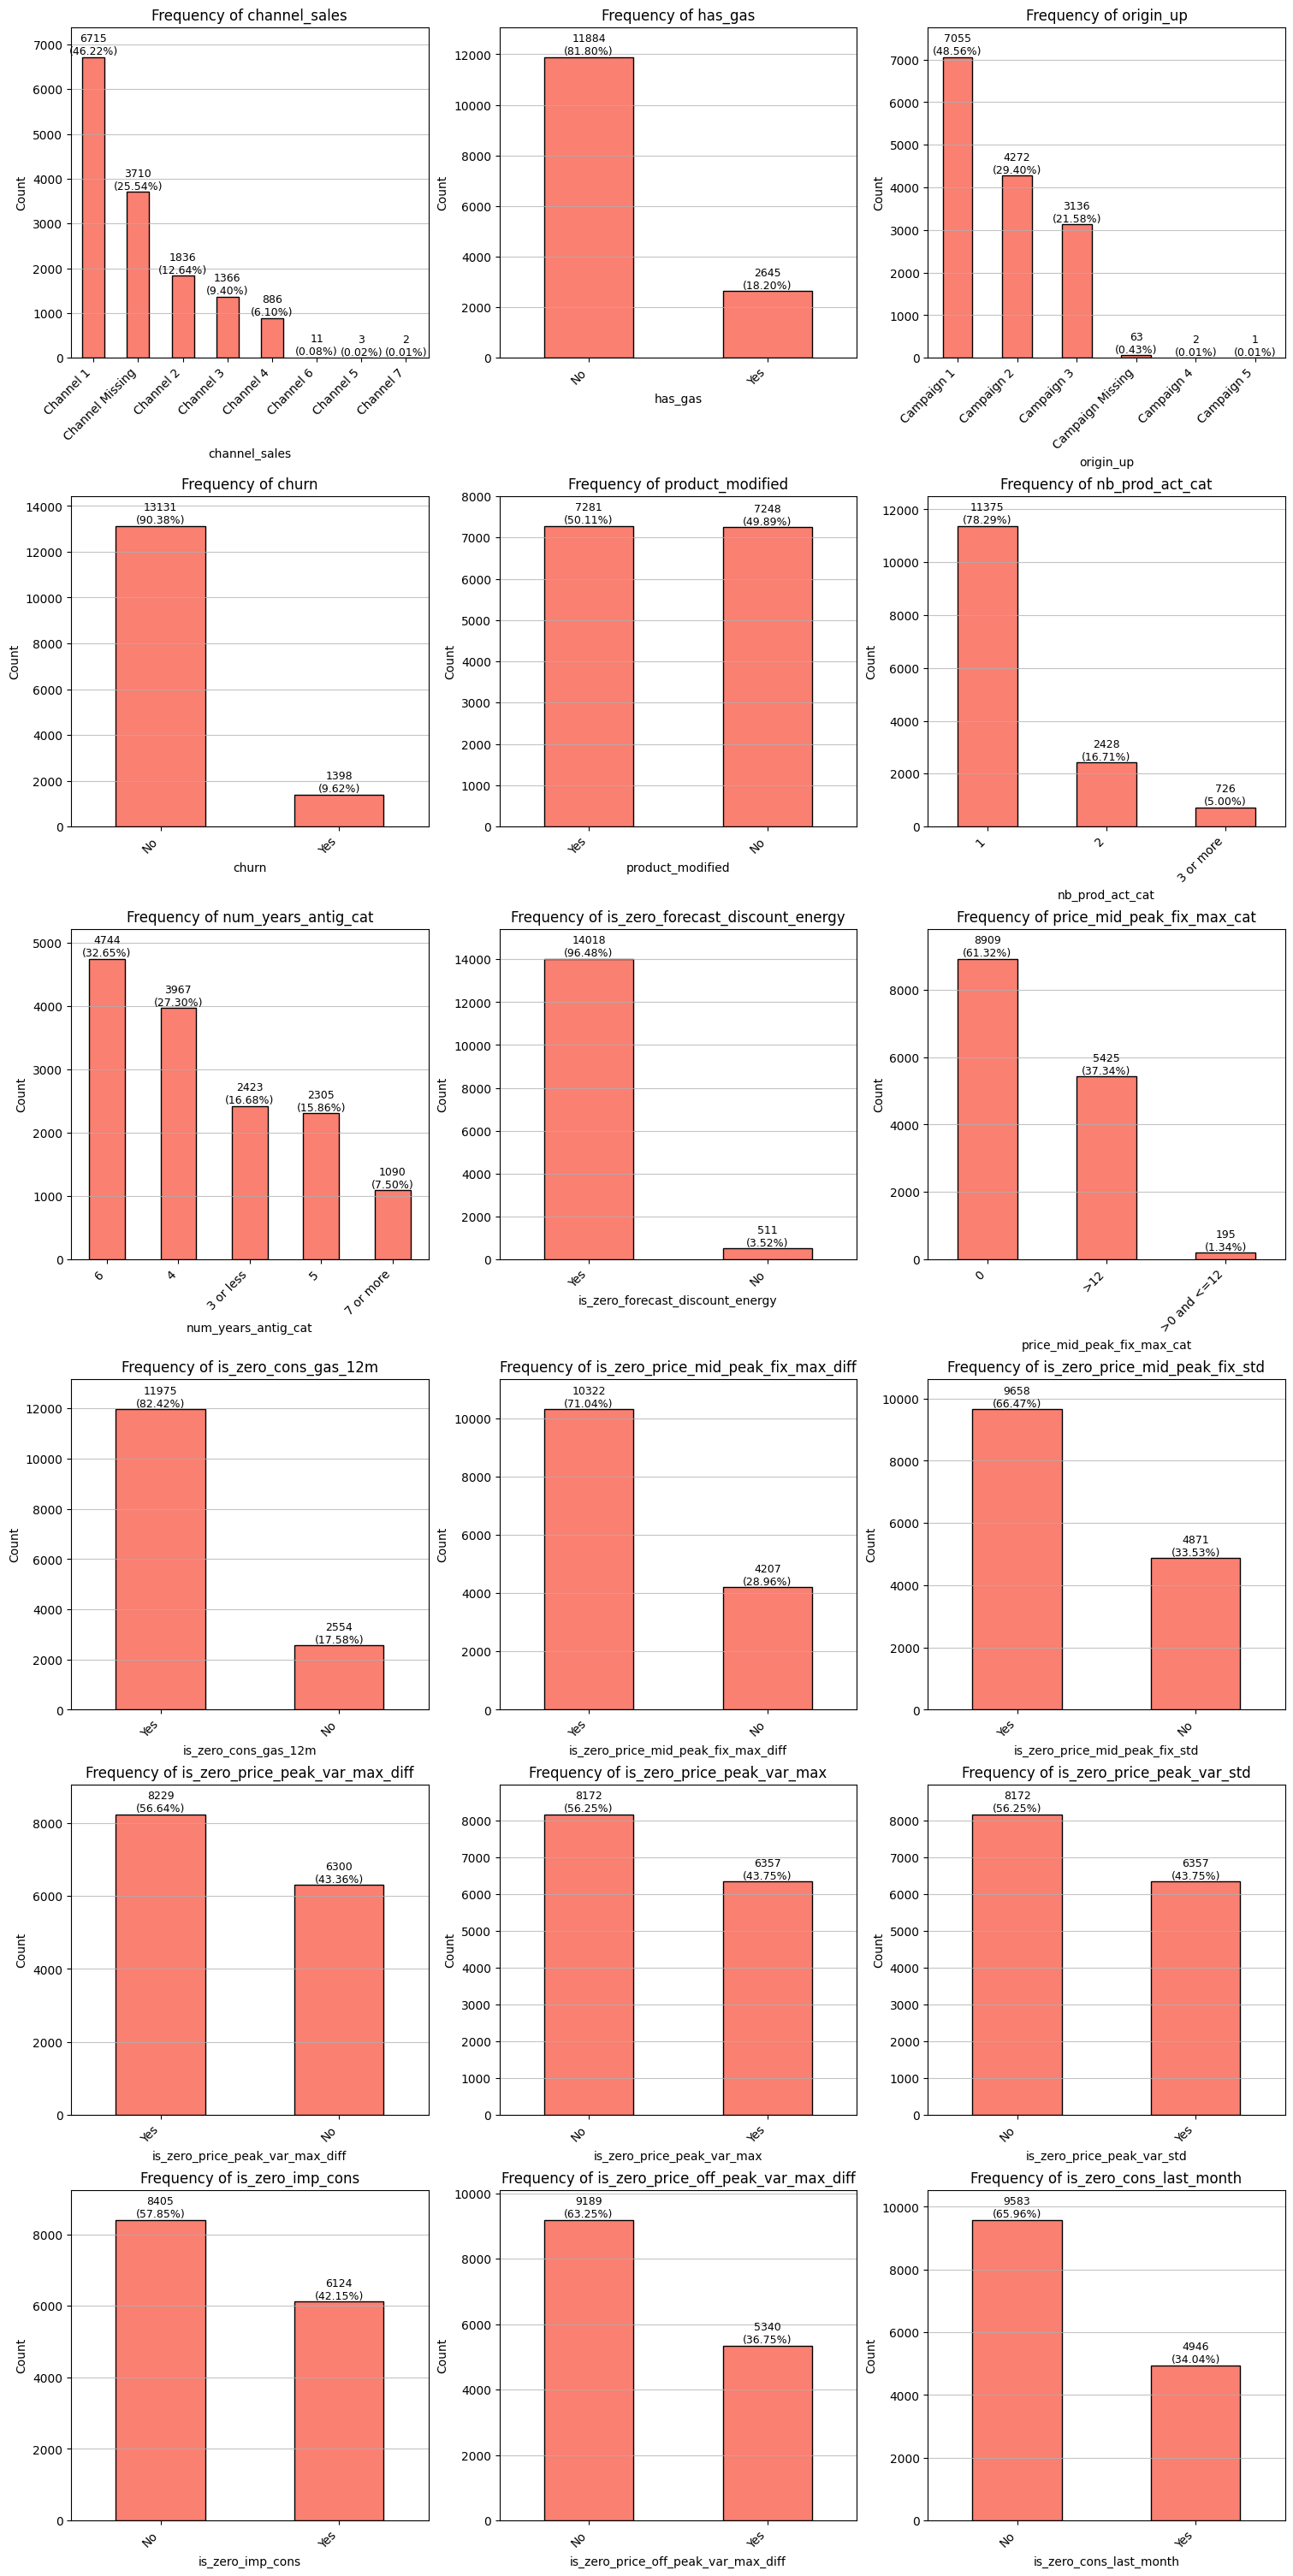

In [67]:
plot_bar_charts(merged_df, categorical_cols, sort_index=False, ncols=3)

As you can see, some categories are very poorly represented:

- `'Channel 5'`, `'Channel 6'` and `'Channel 7'` for the `channel_sales` variable
- `'Campaign 4'`, `'Campaign 5'` and `'Campaign Missing'` for the `origin_up` variable

Since these categories are underrepresented, they are likely to introduce noise into the data without providing sufficient examples to learn meaningful patterns. Therefore, we have decided to remove the rows corresponding to categories that account for less than 1% of the total observations.

In [68]:
merged_df = remove_underrepresented_categories(merged_df, categorical_cols)


Removed categories from 'channel_sales':
  - Channel 6
  - Channel 5
  - Channel 7

Removed categories from 'origin_up':
  - Campaign Missing
  - Campaign 4
  - Campaign 5


In [69]:
merged_df.to_csv(f"{repo_path}/data/merged_data.csv", index=False)